In [1]:
#Set of scalar equations implemented in CAMB, and calculation of the line-of-sight sources
#indices are: g - photons, r- massless neutrinos, c - CDM, b - baryons, de - dark energy, nu - massive neutrinos
# kappa = 8 pi G, Pi is anisotropic stress, q =(rho+p)v the heat flux (and for components rho_i q_i = (rho_i+p_i)v_i)
# z is the perturbation to the expansion, h perturbation to the scale factor, sigma the shear
# phi the Weyl potential, and eta the 3-curvature. Equations are in a general gauge
# Equations are implemented in CAMB in the CDM frame (synchronous gauge, but using variables above). 
# There are functions to convert into Newtonian and synchronous gauge metric variables
# Note the code calls Delta_i density perturbation variables clxi

%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np

In [64]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')
import sympy
from sympy import diff, Eq
from sympy.abc import t, kappa, K, k
from sympy.utilities.codegen import codegen
a, rho, P, rho, H, phi, z, eta, sigma, A, hdot = sympy.symbols('a rho P rho H phi z eta sigma A hdot', cls=sympy.Function)
rho_b, rho_c, rho_g, rho_r, rho_nu, p_b, p_nu, csq_b = sympy.symbols('rho_b, rho_c, rho_g, rho_r, rho_nu, p_b, p_nu, c_sb^2', cls=sympy.Function)
delta, delta_P, Pi,q, Delta_P_nu, Delta_nu  = sympy.symbols('delta, delta_P, Pi, q, Delta_P_nu, Delta_nu', cls=sympy.Function)
Delta_c, Delta_g, Delta_r, Delta_b, Kf = sympy.symbols('Delta_c, Delta_g, Delta_r, Delta_b, Kf', cls=sympy.Function)
v_b, v_c, q_g, q_nu, q_r= sympy.symbols('v_b, v_c, q_g q_nu q_r', cls=sympy.Function)
pi_g, pi_r, pi_nu = sympy.symbols('pi_g pi_r pi_nu', cls=sympy.Function)
rho_de, w_de, csqhat_de, v_de, Delta_de = sympy.symbols('rho_de, w_de, chat_sde^2, v_de, Delta_de', cls=sympy.Function)
#J_3, E_3, G_3 = sympy.symbols('J_3, E_3, G_3', cls=sympy.Function)
opac,drag,photbar, exptau, vis, polter = sympy.symbols('opac drag photbar exptau vis polter', cls=sympy.Function)
#Newtonian gauge variables
Phi, Psi, Phi_N, Psi_N = sympy.symbols('Phi, Psi, Phi_N, Psi_N', cls=sympy.Function)
#Synchronous gauge variables
eta_s, hdot_s = sympy.symbols('eta_s hdot_s', cls=sympy.Function)


def subs(eqs,expr):
    #generalization to act on lists of equations, and support using Eq equations
    if isinstance(expr, (list, tuple)):
        res = [subs(eqs,ex) for ex in expr]
        return [ x for x in res if x != True]
    if isinstance(eqs, dict):
        return expr.subs(eqs)
    else:
        if not isinstance(eqs,(list,tuple)):
            eqs = [eqs]        
        eqs = [(eq.lhs,eq.rhs)for eq in eqs]        
        return expr.subs(eqs)

def solve(eq, x):
    res= sympy.solve(eq,x)
    if len(res)==1:
        return res[0]
    else:
        return res

half = sympy.Rational(1,2)
third = sympy.Rational(1,3)
K_fac = Kf(1)
K_fac_sub = (1-3*K/k**2);
K_sub = Eq(K,solve(K_fac_sub-K_fac,K))
sympy.init_printing()


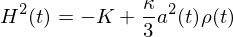

In [3]:
H_t = diff(a(t),t)/a(t)
dH = -a(t)**2/6*kappa*(rho(t)+3*P(t))
Friedmann = Eq(H(t)**2,a(t)**2*kappa*rho(t)/3-K)
Friedmann

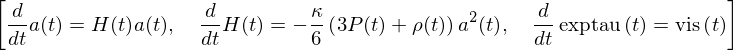

In [4]:
background_eqs = [
    Eq(diff(a(t),t),H(t)*a(t)),
    Eq(diff(H(t),t),dH),
    Eq(diff(exptau(t),t),vis(t))
]
background_eqs

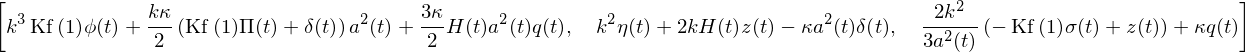

In [5]:
#constraint equations relating variables
cons1 = k**3*K_fac*phi(t)+kappa/2*(a(t))**2*k*(delta(t)+Pi(t)*K_fac)  +3*kappa/2*a(t)**2*H(t)*q(t)
cons2 = k**2*eta(t)-kappa*a(t)**2*delta(t) + 2*k*H(t)*z(t)
cons3 = 2*third*(k/a(t))**2*(z(t)-K_fac*sigma(t))+kappa*q(t)
cons4 = hdot(t) - k/3*z(t)+H(t)*A(t)
constraints = [cons1,cons2, cons3]
constraints

In [6]:
phi_sub = Eq(phi(t),solve(cons1,phi(t)))

In [7]:
#Eliminate z [perturbation in expansion rate] in favour of the curvature perturbation eta
z_sub=Eq(z(t),solve(cons2,z(t)))

In [8]:
sigma_sub=Eq(sigma(t),subs(z_sub,solve(cons3,sigma(t))))

In [9]:
hdot_sub = Eq(hdot(t),subs(z_sub,solve(cons4,hdot(t))))

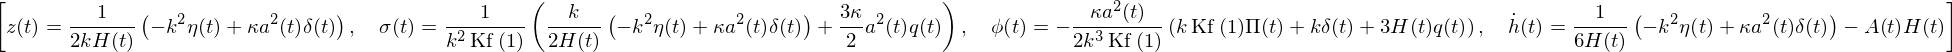

In [10]:
var_subs=  [z_sub,sigma_sub,phi_sub,hdot_sub]
var_subs

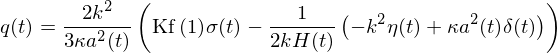

In [11]:
q_sub = Eq(q(t),subs(z_sub,solve(cons3,q(t))))
q_sub


In [12]:
dz = -H(t)*z(t) - kappa*a(t)**2/k/2*(delta(t)+3*delta_P(t)) + (3*kappa*a(t)**2*(rho(t)+P(t))/2)*A(t)/k+k*K_fac*A(t)

In [13]:
dsigma=-H(t)*sigma(t)+k*(phi(t)+A(t))-half*kappa*a(t)**2/k*Pi(t)

In [14]:
deta = -1/k*(2*K*z(t) + kappa*a(t)**2*q(t) +2*K_fac*k*H(t)*A(t))

In [15]:
dphi = -H(t)*phi(t)+half/k**2*kappa*a(t)**2*(k*(rho(t)+P(t))*sigma(t)+k*q(t)-diff(Pi(t),t)-H(t)*Pi(t))

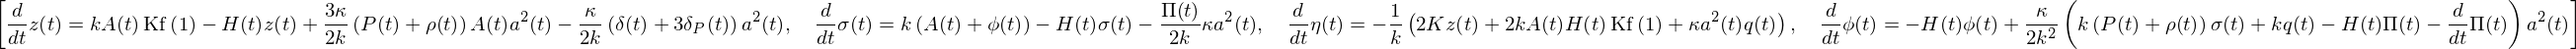

In [16]:
pert_eqs = [
    Eq(diff(z(t),t),dz),
    Eq(diff(sigma(t),t),dsigma),
    Eq(diff(eta(t),t),deta),
    Eq(diff(phi(t),t), dphi)]
pert_eqs

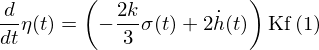

In [17]:
assert(subs(K_sub,subs(var_subs,subs(q_sub,deta).simplify()-K_fac*(2*hdot(t) - 2*k/3*sigma(t)))).simplify()==0)
Eq(diff(eta(t),t), K_fac*(2*hdot(t)-2*k/3*sigma(t))) 

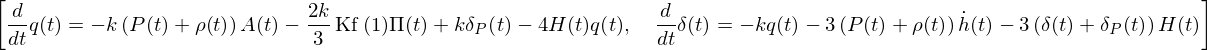

In [18]:
drag_t=opac(t)*(4*v_b(t)/3-q_g(t))
photbar_t =rho_g(t)/rho_b(t);
dgrho_t =kappa*a(t)**2*delta(t);

total_eqs = [
     Eq(diff(q(t),t),k*delta_P(t)-4*H(t)*q(t)-2*third*k*K_fac*Pi(t) -(rho(t)+P(t))*k*A(t)),
     Eq(diff(delta(t),t),-k*q(t) - 3*H(t)*(delta(t) + delta_P(t)) - 3*hdot(t)*(rho(t)+P(t)))
]

tot_eqs = total_eqs + pert_eqs + background_eqs
total_eqs

In [19]:
#check consistency of constraint equations with evolution equations
assert(subs(var_subs,subs(tot_eqs,diff(cons3,t))).simplify()==0)
assert(subs(Friedmann,subs(var_subs,subs(tot_eqs,diff(cons2,t))).simplify()).simplify()==0)
assert(subs(K_sub,subs(Friedmann,subs(var_subs,subs(tot_eqs,diff(cons1,t))).simplify())).simplify()==0)

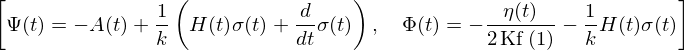

In [20]:
#Newtonian gauge variables in general. Note sigma here is the shear, Pi the anisotropic stress
Newt_vars = [Eq(Psi(t), -A(t) + (diff(sigma(t),t)+H(t)*sigma(t))/k), Eq(Phi(t),-eta(t)/2/K_fac - H(t)*sigma(t)/k)]
assert(subs(var_subs,subs(pert_eqs,subs(Newt_vars,Phi(t)+Psi(t)-2*phi(t)))).simplify()==0)
Newt_vars

Newtonian gauge variables $\Psi$ and $\Phi$ (not used in CAMB but may be useful) defined for metrix sign choices so flat metric is
$$ds^2 = a(\eta)^2\left( (1+2\Psi)d\eta^2 - (1-2\Phi)\delta_{ij}dx^idx^j\right)$$
(default, as defined by [Ma and Bertschinger](https://arxiv.org/abs/astro-ph/9506072), number count and 21cm papers, etc.)
or
$$ds^2 = a(\eta)^2\left( (1+2\Psi_N)d\eta^2 - (1+2\Phi_N)\delta_{ij}dx^idx^j\right)$$
(as defined by [Hu et.al.](https://arxiv.org/abs/astro-ph/9709066), lensing review, etc.) 


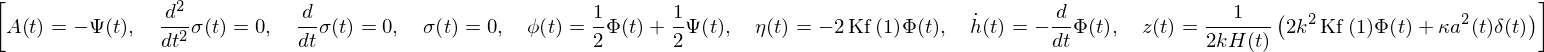

In [21]:
Newtonian_subs1 = [Eq(Phi(t),phi(t)+half*a(t)**2*kappa*Pi(t)/k**2),
                   Eq(Psi(t),phi(t)-half*a(t)**2*kappa*Pi(t)/k**2)]

Newtonian_subs2 = [Eq(Phi_N(t),-phi(t)-half*a(t)**2*kappa*Pi(t)/k**2),
 Eq(Psi_N(t),phi(t)-half*a(t)**2*kappa*Pi(t)/k**2)]

#Newtonian gauge has zero shear
Newt_subs = [ Eq(A(t), -Psi(t)), Eq(diff(sigma(t),t,t),0), Eq(diff(sigma(t),t),0), 
             Eq(sigma(t),0), Eq(phi(t),(Phi(t)+Psi(t))/2), Eq(eta(t), -2*Phi(t)*K_fac), Eq(hdot(t), -diff(Phi(t),t))]
Newt_subs+= [subs(Newt_subs,z_sub)]

def newtonian_gauge(x, convention=1):
    if isinstance(x,(list,tuple)):
        return [newtonian_gauge(y) for y in x]
    res = subs(Newt_subs,x)
    if res != True:
        res = res.simplify()
        res2 = res.subs(Psi(t), Phi(t) - a(t)**2*kappa*Pi(t)/k**2).simplify()
        if len(str(res2)) < len(str(res)):
            res= res2
        if convention==2:
            return res.subs(Phi(t), -Phi_N(t)).subs(Psi(t),Psi_N(t))
        else:
            return res
    else:
        return res


assert(newtonian_gauge(dsigma)==0)

Newt_subs

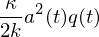

In [22]:
#e.g. get the Newtonian gauge equation for diff(Phi(t),t) + H(t)*Psi(t) 
#[eq 23b of Ma and Bertschinger, noting that their (rho+P)theta = k q since q = (rho+P)v]
newtonian_gauge(subs(tot_eqs,subs(Newtonian_subs1,(diff(Phi(t),t) + H(t)*Psi(t))).simplify().doit()))

In [23]:
#Relations for setting the sychronous gauge. note however that hdot and eta still differ from Ma & Bertshinger by factors
#zero acceleration, comoving with CDM
sync_subs = [Eq(diff(A(t),t),0), Eq(A(t),0), Eq(v_c(t),0)]
def cdm_gauge(x):
    if isinstance(x,(list,tuple)):
        return [cdm_gauge(y) for y in x]
    return subs(sync_subs,x).simplify()
    

Define synchonous gauge variables in Ma and Bertschinger notation (generalized to non-flat)

In terms of [Hu et al](https://arxiv.org/abs/astro-ph/9709066) variables $h_L+ h_T/3 = \eta_s$ and $h_L = -h_s/6$

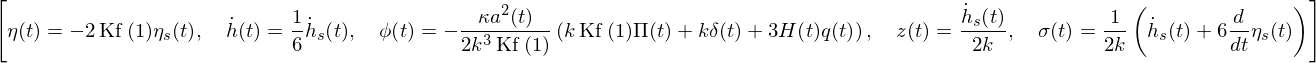

In [24]:
synchronous_subs = [Eq(eta_s(t),-eta(t)/2/K_fac), Eq(hdot_s(t),6*hdot(t))]


synch_subs = [Eq(eta(t),-2*K_fac*eta_s(t)), Eq(hdot(t),hdot_s(t)/6), phi_sub ]
synch_subs += [subs(synch_subs, Eq(z(t), solve(cons4,z(t)))), 
                                Eq(sigma(t),(hdot_s(t)+diff(6*eta_s(t),t))/2/k)]

assert(subs(K_sub,subs(var_subs,subs(pert_eqs,subs(synchronous_subs,subs(synch_subs,sigma(t)) - sigma(t))
                              .doit())).simplify().collect(eta(t))).simplify()==0)

synch_subs = cdm_gauge(synch_subs)

def synchronous_gauge(x, convention=1):
    if isinstance(x,(list,tuple)):
        return [synchronous_gauge(y) for y in x]
    res = subs(synch_subs,cdm_gauge(x))
    if res != True:
        return res.simplify()
    else:
        return res

synch_subs

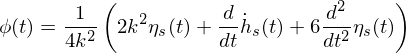

In [25]:
#Alternative pure-metric expression for phi
Eq(phi(t),subs(Eq(Pi(t),-(3*diff(eta_s(t),t,t)+diff(hdot_s(t),t)/2 + 2*(3*H(t)*diff(eta_s(t),t) + H(t)*hdot_s(t)/2) - k**2*eta_s(t))/kappa/a(t)**2),
 synchronous_gauge(subs(sympy.solve([var_subs[0],var_subs[1],var_subs[3]], (delta(t), q(t), A(t))), phi_sub).rhs)).simplify())

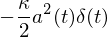

In [26]:
#Check the four synchronous gauge equations
synchronous_gauge(subs(var_subs,subs(synchronous_subs, K_fac*k**2*eta_s(t)-H(t)*hdot_s(t)/2)).simplify())

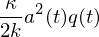

In [27]:
synchronous_gauge(subs(pert_eqs,subs(synchronous_subs, -K/2*hdot_s(t)/k**2 + K_fac*diff(eta_s(t),t)).doit()))

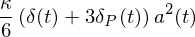

In [28]:
synchronous_gauge(subs(K_sub,subs(Friedmann,subs(var_subs,subs(total_eqs,subs(background_eqs,subs(pert_eqs,subs(var_subs,
        subs(synchronous_subs, -(diff(hdot_s(t),t) + H(t)*hdot_s(t))/6).doit()).doit())).simplify().expand())
    ).simplify().expand())).simplify())

In [29]:
#Seems to be a factor of 2 missing in last line of eq A8 of Hu et al.
synchronous_gauge(subs(q_sub,subs(K_sub,subs(Friedmann,subs(var_subs,subs(tot_eqs+background_eqs,subs(var_subs,subs(pert_eqs,subs(synchronous_subs,
    3*diff(eta_s(t),t,t)+diff(hdot_s(t),t)/2 + 2*(3*H(t)*diff(eta_s(t),t) + H(t)*hdot_s(t)/2) - k**2*eta_s(t)).doit()).doit()).doit()))
                  .simplify()))))

In [30]:
#Fluid components

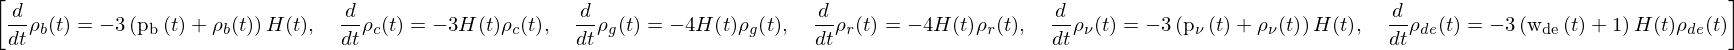

In [31]:
density_eqs = [
 Eq(diff(rho_b(t),t),-3*H(t)*(rho_b(t)+p_b(t))),
 Eq(diff(rho_c(t),t),-3*H(t)*(rho_c(t))),
 Eq(diff(rho_g(t),t),-4*H(t)*(rho_g(t))),
 Eq(diff(rho_r(t),t),-4*H(t)*(rho_r(t))),
 Eq(diff(rho_nu(t),t),-3*H(t)*(rho_nu(t)+p_nu(t))),
 Eq(diff(rho_de(t),t),-3*H(t)*(rho_de(t)*(1+w_de(t))))
]
density_eqs


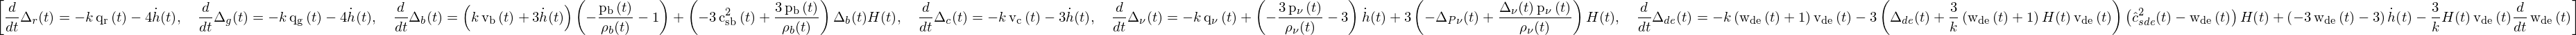

In [32]:
delta_eqs = [
   Eq(diff(Delta_r(t),t),-4*hdot(t)-k*q_r(t)),
   Eq(diff(Delta_g(t),t),-4*hdot(t)-k*q_g(t)),
   Eq(diff(Delta_b(t),t),-(1+p_b(t)/rho_b(t))*(3*hdot(t)+k*v_b(t))
                       +(p_b(t)/rho_b(t)-csq_b(t))*3*H(t)*Delta_b(t)),
   Eq(diff(Delta_c(t),t), -3*hdot(t) -k*v_c(t)),
   Eq(diff(Delta_nu(t),t), -3*(1+p_nu(t)/rho_nu(t))*hdot(t) 
            - k*q_nu(t) +3*H(t)*(-Delta_P_nu(t) + Delta_nu(t)*p_nu(t)/rho_nu(t))),
   Eq(diff(Delta_de(t),t), 
      -3*(1+w_de(t))*hdot(t)-(1+w_de(t))*k*v_de(t)-3*H(t)*(csqhat_de(t)-w_de(t))*(Delta_de(t)+3*H(t)*(1+w_de(t))*v_de(t)/k)
     - 3*H(t)*diff(w_de(t),t)*v_de(t)/k)  
]
delta_eqs

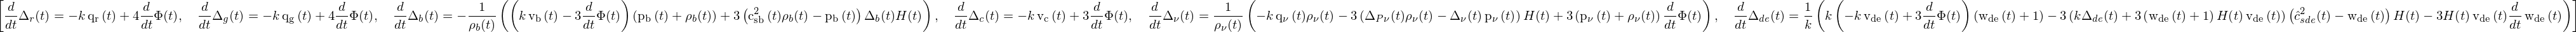

In [33]:
newtonian_gauge(delta_eqs)

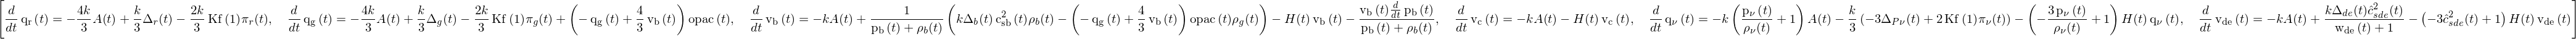

In [34]:
vel_eqs = [
    Eq(diff(q_r(t),t),-2*third*k*pi_r(t)*K_fac+third*k*Delta_r(t)-4*k/3*A(t)), 
    Eq(diff(q_g(t),t),-2*third*k*pi_g(t)*K_fac+third*k*Delta_g(t)+drag_t-4*k/3*A(t)),
    Eq(diff(v_b(t),t),-k*A(t)-H(t)*v_b(t) - diff(p_b(t),t)*v_b(t)/(rho_b(t)+p_b(t))
              +1/(rho_b(t)+p_b(t))*(rho_b(t)*csq_b(t)*k*Delta_b(t)-rho_g(t)*drag_t)),
    Eq(diff(v_c(t),t),-H(t)*v_c(t)-k*A(t)),
    Eq(diff(q_nu(t),t),-H(t)*(1-3*p_nu(t)/rho_nu(t))*q_nu(t) 
             -k/3*(2*K_fac*pi_nu(t) - 3*Delta_P_nu(t))-(1+p_nu(t)/rho_nu(t))*k*A(t)),
    Eq(diff(v_de(t),t),k*csqhat_de(t)*Delta_de(t)/(1+w_de(t))-H(t)*(1-3*csqhat_de(t))*v_de(t) - k*A(t) )
]
vel_eqs

In [35]:
component_eqs = density_eqs + delta_eqs + vel_eqs

In [36]:
rho_t =rho_b(t)+rho_c(t)+rho_r(t)+rho_g(t)+rho_nu(t)+ rho_de(t)

In [37]:
P_t=third*(rho_r(t)+rho_g(t))+p_b(t)+p_nu(t) + w_de(t)*rho_de(t)

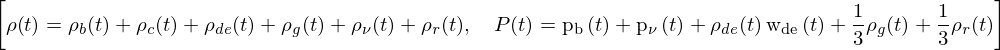

In [38]:
tot_subs = [
    Eq(rho(t), rho_t),
    Eq(P(t), P_t)
]
tot_subs

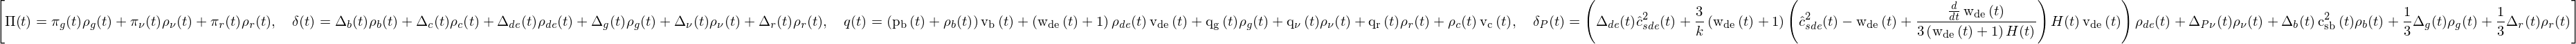

In [39]:
#Note that csqhat_de is defined in the dark energy rest-frame, so this is general-gauge result for pressure perturbation:
Delta_P_de =  (csqhat_de(t)*Delta_de(t) + 3*H(t)*v_de(t)/k*(1+w_de(t))*(csqhat_de(t)-w_de(t) + diff(w_de(t),t)/3/H(t)/(1+w_de(t))))
tot_pert_subs = [
    Eq(Pi(t), rho_g(t)*pi_g(t)+rho_r(t)*pi_r(t) + rho_nu(t)*pi_nu(t)),
    Eq(delta(t),rho_g(t)*Delta_g(t)+rho_r(t)*Delta_r(t)+rho_b(t)*Delta_b(t)+rho_c(t)*Delta_c(t) 
             +rho_nu(t)*Delta_nu(t) + rho_de(t)*Delta_de(t)),
    Eq(q(t),rho_g(t)*q_g(t)+rho_r(t)*q_r(t)+rho_c(t)*v_c(t)+(rho_b(t)+p_b(t))*v_b(t) + rho_nu(t)*q_nu(t)+ rho_de(t)*(1+w_de(t))*v_de(t)),
    Eq(delta_P(t),rho_nu(t)*Delta_P_nu(t) + third*(rho_g(t)*Delta_g(t)+rho_r(t)*Delta_r(t)) +csq_b(t)*Delta_b(t)*rho_b(t)
        + Delta_P_de*rho_de(t))

]
tot_pert_subs

In [40]:
def make_index_func(name,l, namespace = globals()):
    name += '_'+str(l)
    if not name in namespace:
        namespace[name] = sympy.Function(name)
    return namespace[name]

#Boltzmann hierarchies
def J_eq(l):
  #photons
  assert(l>1) 
  Gl = make_index_func('J',l)
  Glp = make_index_func('J',l+1)
  Glm = make_index_func('J',l-1)
  eq=-k/(2*l+1)*( (l+1)*Kf(l)*Glp(t) - l*Glm(t)) - opac(t)*Gl(t)
  if l==2: eq = eq +  8*k/15*sigma(t) + opac(t)*polter(t)
  return Eq(diff(Gl(t),t),eq).subs('J_2(t)', pi_g(t)).subs('J_1(t)', q_g(t))

def G_eq(l):
  #massless neutrinos
  assert(l>1) 
  Gl = make_index_func('G',l)
  Glp = make_index_func('G',l+1)
  Glm = make_index_func('G',l-1)
  eq=-k/(2*l+1)*( (l+1)*Kf(l)*Glp(t) - l*Glm(t));
  if l==2: eq = eq +  8*k/15*sigma(t)
  return Eq(diff(Gl(t),t),eq).subs('G_2(t)', pi_r(t)).subs('G_1(t)', q_r(t))

def E_eq(l):
  #E polarization  
  assert(l>1)
  El = make_index_func('E',l)
  Elp = make_index_func('E',l+1)
  Elm = make_index_func('E',l-1)
  eq = -k/(2*l+1)*( (l+3)*(l-1)*Kf(l)*Elp(t)/(l+1) - l*Elm(t))-opac(t)*El(t);
  if l==2:
    eq = eq +polter(t)*opac(t)
  return Eq(diff(El(t),t),eq).subs('E_1(t)', 0)


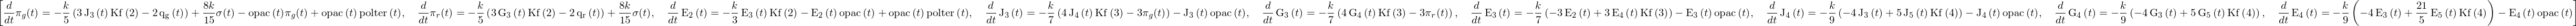

In [41]:
hierarchies = []
for l in range(2,5):
    hierarchies+= [J_eq(l), G_eq(l), E_eq(l)]
hierarchies    

In [42]:
#Check consistency of fluid equations with equations from total stress-energy conservation
for eq in total_eqs:
    assert(subs(component_eqs+tot_subs,subs(tot_pert_subs,eq).doit()).doit().simplify())

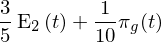

In [43]:
polter_t = sympy.Rational(2,15)*(3*pi_g(t)/4 + 9*E_2(t)/2)
#quadrupole source =15*polter_t/8
polter_t

In [44]:
#Line of sight temperature anisotropy source

source1 = k*sigma(t)*exptau(t) +vis(t)*15*polter(t)/8
source = source1/3+diff(source1,t,t)/k**2 +vis(t)*Delta_g(t)/4-hdot(t)*exptau(t) +diff(vis(t)*v_b(t)-k*exptau(t)*A(t),t)/k

In [45]:
src=subs(var_subs,subs(background_eqs+pert_eqs,subs(background_eqs+pert_eqs,source).expand().doit()).simplify()).simplify().expand()

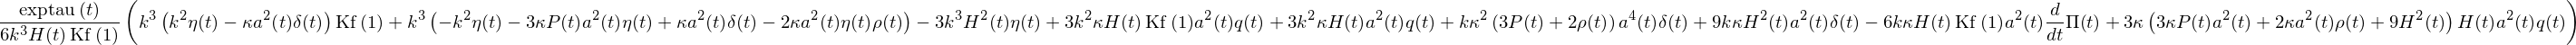

In [46]:
ISW = src.coeff(exptau(t))*exptau(t)
ISW.simplify()

In [47]:
#Check ISW is just 2*d phi/d eta
assert(subs(K_sub,subs(Friedmann,subs(K_sub,subs(Friedmann,subs(var_subs,2*dphi*exptau(t) - ISW).simplify())).simplify())).simplify()==0)

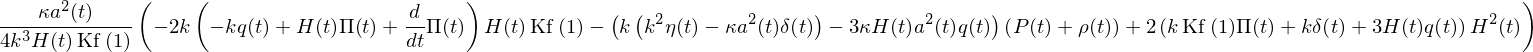

In [48]:
subs(var_subs,dphi).simplify()

In [49]:
Doppler = subs(var_subs,subs(pert_eqs,diff(vis(t)*(v_b(t)+sigma(t)),t)/k)).simplify().collect(vis(t))

In [50]:
remainder = src - ISW-Doppler

In [51]:
remainder=remainder.simplify().collect(vis(t))

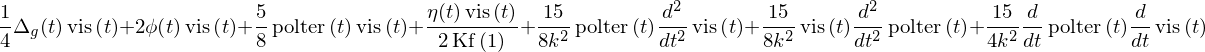

In [52]:
remainder=remainder.subs(delta(t),solve(phi_sub, delta(t))).simplify()
remainder

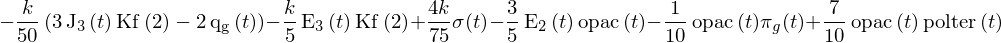

In [53]:
polterdot = subs(hierarchies,diff(polter_t,t))
polterdot

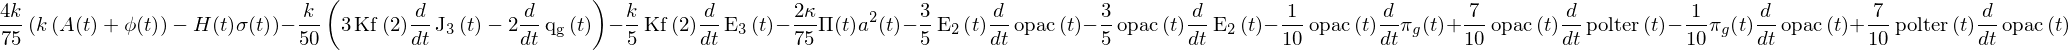

In [54]:
diff(polterdot,t).subs(diff(sigma(t),t),dsigma).simplify()

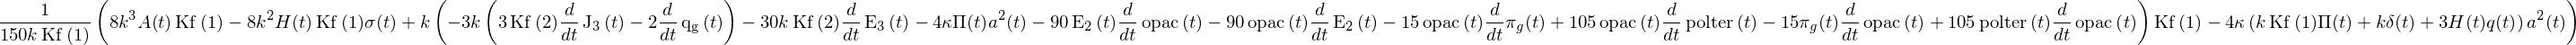

In [55]:
polterddot = subs(phi_sub,diff(polterdot,t).subs(diff(sigma(t),t),dsigma).simplify()).simplify()
polterddot

In [56]:
monopole_source = Delta_g(t)*vis(t)/4  
sachs_wolfe = 2*phi(t)*vis(t) + eta(t)*vis(t)/(2*Kf(1)) 
quadrupole_source = (remainder-sachs_wolfe - monopole_source).simplify()
dop = diff((v_b(t)+sigma(t))*vis(t),t)/k
#check this is equal to the form of the Doppler source above
assert(subs(var_subs,subs(pert_eqs,(dop-Doppler))).simplify()==0)

In [95]:
#for translation in source output routine (does not include all equation variable)

def camb_fortran(expr, name= 'camb_function', expand =False):
    etakdot, etak, j, qg, vb, qr, qgdot, qrdot, vbdot, pig, pigdot, pir, pirdot, pinu, pinudot, dgq, a, sigma, adotoa, octg, octgprime = \
    sympy.symbols('etakdot etak j qg vb qr qgdot qrdot vbdot pig pigdot pir pirdot pinu pinutdot dgq, a, sigma,adotoa, octg, octgprime')
    ddvis, dvis, dopac = sympy.symbols('ddvis dvis dopac', cls= sympy.Function)
    clxg, ypolprime, ypol, gpres, grho, polter, polterdot,polterddot, dgpi, phi, diff_rhopi, expmmu, dgrho, sigmadot, phidot = \
      sympy.symbols('clxg ypolprime ypol gpres grho polter polterdot polterddot dgpi, phi, diff_rhopi, expmmu, dgrho sigmadot phidot')

    #Keep everything except baryons pressure which is very small
    camb_diff_subs= [(diff(q_g(t),t),qgdot),(diff(pi_g(t),t),pigdot),(diff(pi_r(t),t),pirdot),
               (diff(q_r(t),t),qrdot),(diff(v_b(t),t),vbdot),(diff(a(t),t), a*adotoa), 
               (diff(vis(t),t,t),ddvis(j)),(diff(vis(t),t),dvis(j)), (diff(opac(t),t),dopac(j)),
               (diff(J_3(t),t),octgprime), (diff(E_2(t),t),ypolprime(2)),
               (diff(E_3(t),t),ypolprime(3)), (diff(pi_nu(t),t),pinudot),
               (diff(eta(t),t),-2*etakdot/k),(diff(Pi(t),t), diff_rhopi/kappa/a**2),
               (diff(polter(t),t,t),polterddot),(diff(polter(t),t),polterdot),
                    (diff(sigma(t),t), sigmadot), (diff(phi(t),t), phidot), (diff(p_b(t),t),0)]

    camb_subs= [(p_b(t),0),(q(t),dgq/kappa/a**2), (H(t),adotoa),(a(t),a),(sigma(t),sigma), 
               (v_b(t),vb), (pi_g(t),pig),(pi_r(t),pir),(q_g(t),qg),
               (z(t),z),(Delta_g(t),clxg),(E_2(t),ypol(2)), (delta(t), dgrho/kappa/a**2),
               (E_3(t),ypol(3)), (polter(t),polter),(J_3(t), octg), 
               (pi_nu(t),pinu), (P(t),gpres/kappa/a**2),(rho(t),grho/kappa/a**2),
               (eta(t),-2*etak/k), (phi(t),phi), (Pi(t),dgpi/a**2/kappa), (exptau(t), expmmu(j)), (t,j)]
    
    res = cdm_gauge(expr).subs(camb_diff_subs)
    if 'Derivative' in str(res):
        raise Exception('Remaining derivatives: ' + str(res))
    res = res.subs(camb_subs).simplify()
    if expand: res = res.expand()
    res = res.collect([opac(j), dopac(j), expmmu(j), vis(j)])
    res = codegen((name, res), 'f95', 'my_project', header=False)[0][1]
    lines  = res.split('\n')
    for i,line in enumerate(lines):
        if '=' in line:
            res = '\n'.join(lines[i:-2])
            break
    return res.strip().replace('Kf', 'EV%Kf').replace('.0)',')')    

In [96]:
print camb_fortran(dphi, 'phidot')
print camb_fortran(dsigma, 'sigmadot')
print camb_fortran(diff(polter_t,t), 'polterdot')
print camb_fortran(polterddot, 'polterddot')
print camb_fortran(2*diff(phi(t),t)*exptau(t),'ISW')
print camb_fortran(sachs_wolfe, 'sachs_wolfe', expand=True)
print camb_fortran(monopole_source, 'monopole_source')
print camb_fortran(dop, 'doppler')
print camb_fortran(quadrupole_source, 'quadrupole_source')


phidot = (1.0d0/2.0d0)*(-adotoa*dgpi - 2*adotoa*k**2*phi + dgq*k - &
      diff_rhopi + k*sigma*(gpres + grho))/k**2
sigmadot = -adotoa*sigma - 1.0d0/2.0d0*dgpi/k + k*phi
polterdot = (1.0d0/10.0d0)*pigdot + (3.0d0/5.0d0)*ypolprime(2)
polterddot = -2.0d0/25.0d0*adotoa*dgq/(k*EV%Kf(1)) - 4.0d0/75.0d0*adotoa* &
      k*sigma - 4.0d0/75.0d0*dgpi - 2.0d0/75.0d0*dgrho/EV%Kf(1) - 3.0d0/ &
      50.0d0*k*octgprime*EV%Kf(2) + (1.0d0/25.0d0)*k*qgdot - 1.0d0/5.0d0 &
      *k*EV%Kf(2)*ypolprime(3) + (-1.0d0/10.0d0*pig + (7.0d0/10.0d0)* &
      polter - 3.0d0/5.0d0*ypol(2))*dopac(j) + (-1.0d0/10.0d0*pigdot &
      + (7.0d0/10.0d0)*polterdot - 3.0d0/5.0d0*ypolprime(2))*opac(j)
ISW = 2*phidot*expmmu(j)
sachs_wolfe = (-etak/(k*EV%Kf(1)) + 2*phi)*vis(j)
monopole_source = (1.0d0/4.0d0)*clxg*vis(j)
doppler = ((sigma + vb)*dvis(j) + (sigmadot + vbdot)*vis(j))/k
quadrupole_source = (5.0d0/8.0d0)*(3*polter*ddvis(j) + 6*polterdot*dvis( &
      j) + (k**2*polter + 3*polterddot)*vis(j))/k**2
